# Before runing the code, you have to extract datasets folders and put it in the same folder as main_file

## General Introduction

Among the five input parameters S, K, T, r, and $\sigma$ in the Black-Scholes formulas, only the volatility $\sigma$ is not directly observable.  
In this project, we will study different types of models for estimating $\sigma$.

## Implied Volatility

An acceptable solution for estimating $\sigma$ would be to invert the Black-Scholes formula and use the market price of the option to derive the implied volatility.

Firstly, we need to implement the mathematical expression the **Call Option Price**.

$$
C = S_0 \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)
$$ 

where :
- $
d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}}
$
- $
d_2 = d_1 - \sigma \sqrt{T}
$


In [164]:
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

#Black_Scoles Call Price
def BS_call_price(S,K,T,r,sigma) :
    d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    return S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)



### Newton-Raphson method :

The Newton-Raphson method is an iterative technique used to find the roots of a real-valued function \( f(x) = 0 \).

The formula for the iteration is:
$$
x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}
$$
- Repeat until the solution converges, i.e., until $ |x_{n+1} - x_n| $ is below a specified tolerance.

If we define:
$$
f(\sigma) = \text{Call}(\sigma) - \text{market\_price},
$$
then the implied volatility is a root of \( f(\sigma) \).

We can find the implied volatility using an iterative algorithm such as the Newton-Raphson method. The iteration formula is:
$$
\sigma_{n+1} = \sigma_n - \frac{f(\sigma_n)}{f'(\sigma_n)},
$$



In [165]:
#derivate the Call_price with respect to sigma
def sigma_derivative(S,K,T,r,sigma):
    d1 = (math.log(S/K)+(r +0.5 *sigma ** 2)*T)/(sigma* math.sqrt(T))
    return S*norm.pdf(d1)*math.sqrt(T)

def implied_volatility(S,K,T,r, market_price, tol=1e-10, max_iter=1000):
    sigma = 0.2  
    min_sigma = 1e-8
    i= 0
    diff= tol+ 1

    while i < max_iter and abs(diff) > tol:
        price = BS_call_price(S,K,T,r,sigma)
        diff = price- market_price
        sigma_deriv= sigma_derivative(S,K,T,r,sigma)

        if sigma_deriv == 0:
            sigma= sigma + min_sigma
        else:
            sigma= sigma-diff/sigma_deriv  # Newton-Raphson update

        if sigma<=min_sigma:
            sigma= min_sigma

        i=i+1

    return sigma

<function matplotlib.pyplot.show(close=None, block=None)>

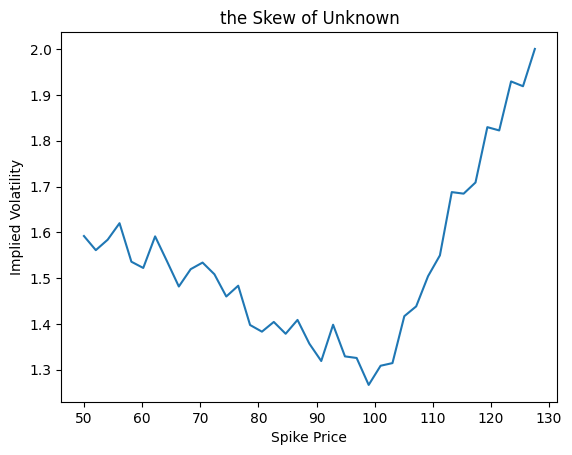

In [297]:
from scipy.optimize import brentq
#We couldn't find easily the data of Call options online.
#So we had to put them manually
S = 59.35#
T = 5/12 #in 1 year
r = 0.03

string = "Unknown"
Calls = [26.64,25.53,25.11,24.9,23.15,22.33,22.66,21.33,19.98,19.97,19.65,18.77,17.56,17.43,15.68,15.01,14.90,14.09,
         14.15,12.97,12.02,12.87,11.47,11.09,9.88,10.20,9.99,11.24,11.28,12.00,12.42,14.26,13.95,14.07,15.67,15.32,16.72,16.33,17.35]


Strikes =[ 50,52.04,54.08,56.12,58.16,60.20,62.24,64.28,66.32,68.36,70.40,72.44,74.48,76.53,78.57,80.61,82.65,84.69,86.73,88.77,90.81,
          92.85,94.89,96.90,98.97,101.02,103.06,105.10,107.14,109.18,111.22,113.26,115.30,117.34,119.38,121.42,123.46,125.51,127.55]

implied_volatilities_1 = []
implied_volatilities_2 = []

for i in range(len(Calls)):
    market_price = Calls[i]  # Current market price
    K = Strikes[i]           # Current strike price
    
    # Define the error function for Brent's method
    def BS_error(sigma):
        return BS_call_price(S, K, T, r, sigma) - market_price
    
    # Use the brentq method to solve for the implied volatility
    try:
        sigma = brentq(BS_error, 1e-5, 5, xtol=1e-6)
        implied_volatilities_2.append(sigma)
    except ValueError:
        # Handle the case where a solution is not found
        implied_volatilities_2.append(float('nan'))


for i in range(len(Calls)) :
    sigma = implied_volatility(S,Strikes[i],T,r,Calls[i],tol=1e-10, max_iter=1000)
    implied_volatilities_1.append(sigma)

plt.title("the Skew of "+string)
plt.xlabel("Spike Price")
plt.ylabel("Implied Volatility")
plt.plot(Strikes,implied_volatilities_2)
plt.show

This curve is **The skew curve** is a critical concept in financial trading, particularly in options markets.
Traders and analysts frequently analyze the skew to gain insights into potential price movements.

However we will not develop this point in this project, we will focus mainly on modelising **volatility**, which we assumed is **constant** in the previous model.

### Why use Stochastic Volatility

Volatility in financial markets is inherently unpredictable and exhibits dynamic behavior, making it unsuitable to be treated as a constant.

**It is more accurate to model volatility as a stochastic process, allowing it to evolve randomly over time while accounting for features like mean reversion, jumps, and long-term variance. Such models provide a more realistic framework for pricing derivatives and managing risk.**

In order to evaluate these models, we will need Historical datasets of actual Equities.

## Setting up the Data 

In the following section, we will be using **datasets of real Stocks** to evalute the upcoming Stochastic Models.
We downloaded the daily dataset provided by **Investing.com** from **01/01/2015** to **28/12/2024**, which is used in the following sections.

Firstly, we need to build some function to access to the downloaded datasets. These functions are provided in the following code :

In [167]:
import pandas as pd 
import numpy as np
import os

#Note that the data that has been used in this project if from 01/01/2015 up to 28/12/2024
#T refers to the last date of the data



#prices of the a certain stock 'string' during the last 'number_of_days'
def get_access_to_data(string,number_of_days) :

    current_dir = os.path.dirname(os.path.abspath(__file__))
    datasets_dir = os.path.join(current_dir, "datasets")
    file_name = string+" Historical Data.csv"
    file_path = os.path.join(datasets_dir, file_name)

    data = pd.read_csv(file_path)
    prices = []
    for i in range(number_of_days) : 
        prices.insert(0, float(data.iloc[i,1]) )

    return prices


#get the first_price starting from the [T-first_date- number_of_days, T-first_date] of a certain stock 'string'
def get_initial_price(string,first_date,number_of_days) :
    current_dir = os.path.dirname(os.path.abspath(__file__))
    datasets_dir = os.path.join(current_dir, "datasets")
    file_name = string+" Historical Data.csv"
    file_path = os.path.join(datasets_dir, file_name)
    data = pd.read_csv(file_path)
    return float(data.iloc[first_date+number_of_days-1,1])


#get the prices of a certain stock 'string' from the the range [T-first_date, T-first_date- number_of_days]
def get_prices(string,first_date,number_of_days) :
    current_dir = os.path.dirname(os.path.abspath(__file__))
    datasets_dir = os.path.join(current_dir, "datasets")
    file_name = string+" Historical Data.csv"
    file_path = os.path.join(datasets_dir, file_name)
    data = pd.read_csv(file_path)
    prices = []
    for i in range(first_date,first_date+number_of_days) : 
        prices.insert(0, float(data.iloc[i,1]) )
    return prices



def last_logarithmic_returns(string,number_of_days) :
    prices = get_access_to_data(string,number_of_days)
    returns = []
    for i in range(len(prices)-1) :
        returns.append(np.log(prices[i+1]/prices[i]))

    return returns



In [168]:

def logarithmic_returns_price(string,first_date,number_of_days,number_coming_days) :
    current_dir = os.path.dirname(os.path.abspath(__file__))
    datasets_dir = os.path.join(current_dir, "datasets")
    file_name = string+" Historical Data.csv"
    file_path = os.path.join(datasets_dir, file_name)
    data = pd.read_csv(file_path)
    prices = get_prices(string,first_date,number_of_days)
    returns = []
    for i in range(len(prices)-1) :
        returns.append(np.log(prices[i+1]/prices[i]))

    coming_price = float(data.iloc[first_date-number_coming_days,1])
    return(returns,coming_price)


#Example : 
print(logarithmic_returns_price("BNP Paribas",70,65,5))


([np.float64(-0.013061136780518836), np.float64(0.03217524646701131), np.float64(-0.011655717608369821), np.float64(-0.0051320367584290144), np.float64(-0.003824732358543285), np.float64(-0.008197452846922354), np.float64(0.035317201838102726), np.float64(-0.007160323513538392), np.float64(0.024202536618788843), np.float64(0.01879249934936732), np.float64(-0.004075879604072559), np.float64(-0.017750069824251504), np.float64(-0.023785604794651843), np.float64(0.008965745933478325), np.float64(0.006470420503781164), np.float64(0.00674918197492833), np.float64(0.004793107115300805), np.float64(-0.0027132727522599953), np.float64(0.007324873514746551), np.float64(0.009788521478396654), np.float64(-0.009471262592486936), np.float64(0.023202169536819944), np.float64(0.0024763981081456442), np.float64(-0.009474327295790263), np.float64(0.007462721201589594), np.float64(-0.0015501475744016733), np.float64(-0.00856903272510129), np.float64(0.005150225976315861), np.float64(-0.012216283483456662

# Logarithmic Returns 

Logarithmic returns are defined as:
\begin{equation}
    r_t = \ln \left(\frac{P_t}{P_{t-1}} \right),
\end{equation}
where $P_t$ is the price of the asset at time $t$. Logarithmic returns are often preferred over simple returns because they are time-additive and facilitate statistical modeling.

In practice, it is common to model logarithmic returns as martingales. As a first approximation, we can use the model:
\begin{equation}
    r_t = \mu + Z_t,
\end{equation}
where $Z_t \sim \mathcal{N}(0, \sigma_t^2)$ is a normal random variable with mean $0$ and variance $\sigma_t^2$.

However, before applying this model to real data, we need to verify its validity. For this purpose, we use the JB Test.

# Jarque-Bera (JB) Test

The **Jarque-Bera (JB) test** is a statistical test used to determine whether a given dataset follows a normal distribution. It specifically examines the **skewness** (asymmetry) and **kurtosis** (peakedness) of the data compared to a normal distribution.

## Hypotheses
- Null Hypothesis (\(H_0\)): The data follows a normal distribution.
- Alternative Hypothesis (\(H_1\)): The data does not follow a normal distribution.

## Test Statistic
The JB test statistic is calculated as:
$$JB = \frac{n}{6} \left( S^2 + \frac{(K - 3)^2}{4} \right)$$

Where:
- n: Sample size  
- S: Skewness of the data, (S = $\frac{\frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^3}{\left(\frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2\right)^{3/2}}$)

- K: Kurtosis of the data, (K = $\frac{\frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^4}{\left(\frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2\right)^2}$)



A **large JB value** and a **small p-value** indicate that the null hypothesis can be rejected, suggesting that the data does not follow a normal distribution.



In [169]:
from scipy.stats import jarque_bera
from scipy.stats import anderson

#JB TEST to test if the data can be modelized using a normal distribution
def JB_test(data, alpha) :
    stat_JB, p_value_JB = jarque_bera(data)
    result = anderson(data, dist='norm')
    if p_value_JB > alpha :
        return 0
    else : 
        return 1




In the folllowing code, we will be applying the JB Test on certain 'strings' (that can be **Equities** or **Forex**) using the dataset of the last **'number_of_days'**.
We will change the last **'number_of_days'** from **start_number_of_days** up to **end_number_of_days**.

**Remark** : This analysis aims to get the maximum **number_of_days** that we should use to assume that the data can be modelized with a normal distribution

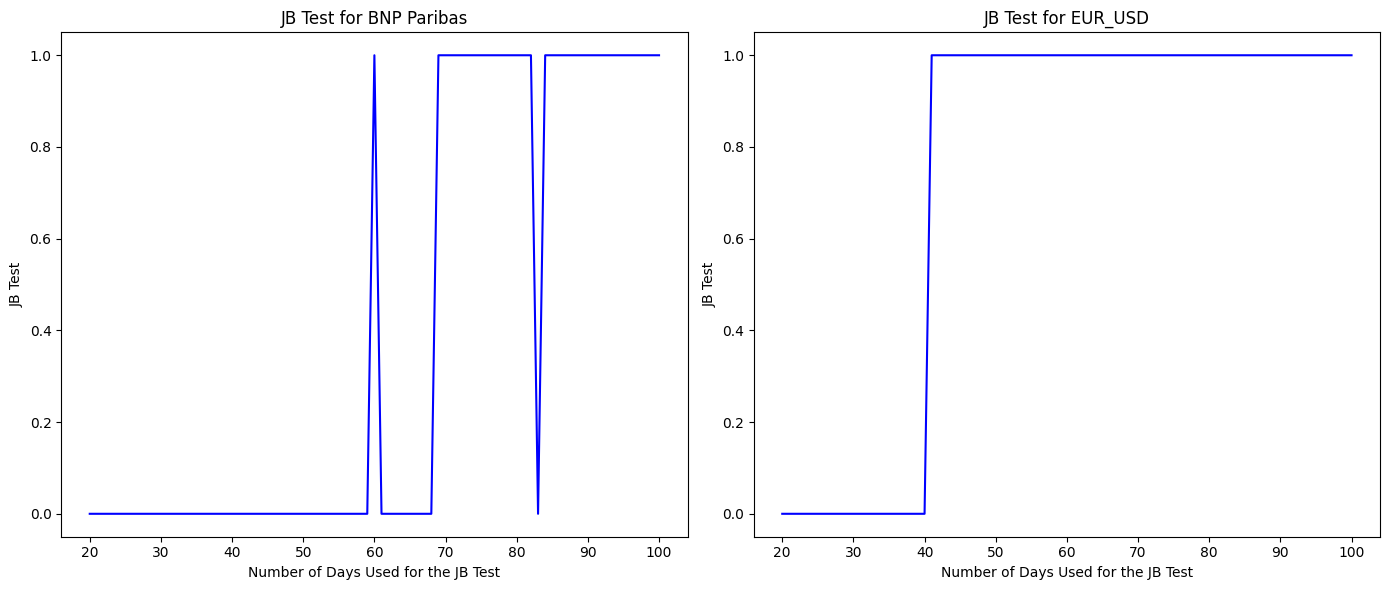

In [170]:

strings = ["BNP Paribas","EUR_USD"]

#you can change these values to be able to deduce which number of days you have to choose to modelize the returns with a normal distribution
start_number_of_days = 20
end_number_of_days = 100
number_of_days_list = [i for i in range(start_number_of_days, end_number_of_days + 1)]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, string in enumerate(strings[:2]):
    results = []  
    for number_of_days in number_of_days_list:
        returns = last_logarithmic_returns(string, number_of_days)
        results.append(JB_test(returns, 0.05))

    axes[i].plot(number_of_days_list, results, color="b")
    axes[i].set_title(f"JB Test for {string}")
    axes[i].set_xlabel("Number of Days Used for the JB Test")
    axes[i].set_ylabel("JB Test")

plt.tight_layout()
plt.show()



These results show that, for instance :
- for BNP Paribas : We should not assume that logarithmic returns are normally distributed if the size of the dataset used is bigger than **60 days**.
- for EUR/USD Forex : We should not assume that logarithmic returns are normally distributed if the size of the dataset used is bigger than **40 days**.

## Ljung-Box Test

The Ljung-Box test is a statistical test used to determine whether a time series exhibits significant autocorrelation at multiple lags.
We will be using it to test if we can model Log returns


- $\textbf{Null Hypothesis}$ ($H_0$): The data are independently distributed; there is no significant autocorrelation at the tested lags.
- $\textbf{Alternative Hypothesis}$ ($H_1$): The data are not independently distributed.

The test statistic is given by:
$$
Q = n(n+2) \sum_{k=1}^m \frac{\hat{\rho}_k^2}{n-k}
$$
where:

- $n$ is the sample size,
- $m$ is the number of lags being tested,
- $\hat{\rho}_k$ is the sample autocorrelation at lag $k$.

A **small p-value** (e.g <0.05) of this test indicate that the the data are not independently distributed.



In [279]:
import statsmodels.api as sm
from scipy.stats import norm

#Ljung_box test
def ljung_box_test(log_returns, lags=10, alpha=0.05):
    lb_result = sm.stats.acorr_ljungbox(log_returns, lags=[lags], return_df=True)
    lb_value = lb_result.loc[10, 'lb_pvalue']
    if float(lb_value) > alpha:
        print('Fail to reject the null Hypothesis')
        return 1
      
    else:
        print('We reject the null Hypothesis')
        return 0 
    

#Example
string = "BNP Paribas"
number_of_days = 5*4*3 #3months (you can change here)

(ljung_box_test(returns))


Fail to reject the null Hypothesis


1

Based on the test results, we can assume that, if we consider the appropriate context (particularly the impact of **number_of_days** in the JB Test) , the Log-returns can be modeled as **independent** and normally distributed variables.

**This hypothesis is crucial and will be necessary in the following section.**

## Volatility Modeling with the GARCH Model

In this section, we aim to model volatility using a widely adopted approach : the GARCH(p, q) model. The mathematical expression of the GARCH(p, q) model is given as follows:

$$
\sigma_t^2 = \omega + \sum_{i=1}^p \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^q \beta_j \sigma_{t-j}^2
$$

where:
- **$\sigma_t^2$**: The conditional variance of the returns at time $t$.  
- **$\omega$**: A constant term representing the long-run variance.
- **$\alpha_i$**: Coefficients representing the ARCH effect.  
- **$\beta_j$**: Coefficients representing the GARCH effect.  
- **$p$**: The order of the ARCH terms (number of past squared residuals included).  
- **$q$**: The order of the GARCH terms (number of past conditional variances included).  

### Conditions for Stationarity and Meaningful Results:
- The sum of $\alpha_i$ and $\beta_j$ should satisfy:  
  $$\sum \alpha_i + \sum \beta_j < 1$$  
- The sum should also be close to $1$ to ensure persistent volatility.


### Garch(1,1) Model

In the following part of the project, we will be interested particularly in the GARCH(1,1) Model as it gives meaningful results in a short amount of time. The expression of the GARCH(1,1) model would be :

$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

Firstly, we aim to estimate this model Params for a certain 'string' (that should be nomally an Equity).

# Estimation of $\mu$, $\omega$, $\alpha$, and $\beta$

Once the logarithmic return model is established, we proceed to model stochastic volatility using GARCH(1,1) model. The Equations of the model can be written as follows : 

$$
r_t = \mu + \epsilon_t,
$$
$$
\epsilon_t = \sigma_t Z_t,
$$
$$
\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2,
$$

where $Z_t \sim \mathcal{N}(0,1)$ and $\omega > 0$, $\alpha \geq 0$, $\beta \geq 0$. For the model to be stable, $\alpha + \beta < 1$.

In practice, $\mu$, $\omega$, $\alpha$, and $\beta$ are estimated using the Maximum Likelihood Estimation (MLE) method. 
**This approach is justified if $r_t$ is a martingale (which is correct according to the Ljung-Box Test results).** 

For $n$ observations, the likelihood function for the GARCH(1,1) model is given by:

$$
L(\mu, \omega, \alpha, \beta) = \prod_{t=1}^n \frac{1}{\sqrt{2\pi \sigma_t^2}} \exp\left(-\frac{\epsilon_t^2}{2\sigma_t^2}\right).
$$

The log-likelihood function, which is maximized in practice, is:

$$
\ln L(\mu, \omega, \alpha, \beta) = -\frac{1}{2} \sum_{t=1}^n \left[ \ln(2\pi \sigma_t^2) + \frac{\epsilon_t^2}{\sigma_t^2} \right].
$$

## Optimization Methodology

To estimate the parameters, we optimize the log-likelihood function using Python's `scipy.optimize` library, which employs stochastic gradient descent methods. Data points could be scaled (e.g., normalized to the range $[1, 100]$) to improve numerical stability and precision.


In [171]:
import statistics
from scipy.optimize import minimize
from scipy.special import gamma



def empirical_mean(string,number_of_days) :
    logarithmic_returns = last_logarithmic_returns(string,number_of_days)
    return np.exp(statistics.mean(logarithmic_returns))


#camculate the log_likelihood knowing the garch parameters
def log_likelihood(params, r_t):
    mu, omega, alpha, beta = params
    T = len(r_t)
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(r_t) 
    Z_t = np.zeros(T)

    #GARCH(1,1) path
    for t in range(1, T):
        Z_t[t-1] = (r_t[t-1] - mu) / np.sqrt(sigma2[t-1])
        sigma2[t] = omega + alpha * (sigma2[t-1] * Z_t[t-1])**2 + beta * sigma2[t-1]

    logL = -0.5 * np.sum(np.log(2 * np.pi * sigma2) + (r_t - mu)**2 / sigma2)
    return -logL


#get garch parameters that maximis the likelihood
def optimize_likelihood(init_params,r_t) :
    constraints = [
        {'type': 'ineq', 'fun': lambda params: 1.00 - (params[2] + params[3])},  # alpha + beta < 1.00
        
        {'type': 'ineq', 'fun': lambda params: params[1] - 1e-5}             # omega >= 10^-5
    ]
    bounds = [(None, None), (1e-6, None), (1e-6, None), (1e-6, 1)]
    #minimizing the log_likelihood
    result = minimize(log_likelihood, init_params, args=(r_t,), bounds=bounds, constraints=constraints, method='SLSQP')
    mu, omega, alpha, beta = result.x
    return mu,omega,alpha,beta


#Example
strings = ["BNP Paribas"]

for string in strings :
    r_t = last_logarithmic_returns(string,52*5) #using the data of the last year
    init_params = [np.mean(r_t),0.1,0.1,0.8]
    print(string)
    mu,omega,alpha,beta = optimize_likelihood(init_params,r_t)
    print("mu = "+str(mu))
    print("omega = "+str(omega))    
    print("alpha = "+str(alpha))   
    print("beta = "+str(beta))   

BNP Paribas
mu = -0.0002736370860916942
omega = 0.00012682219914653071
alpha = 0.4697123532420867
beta = 0.45732894537713253


C:\Users\TNANI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\TNANI\AppData\Local\Temp\ipykernel_32152\2107095434.py:23: RuntimeWarning: overflow encountered in scalar power
  sigma2[t] = omega + alpha * (sigma2[t-1] * Z_t[t-1])**2 + beta * sigma2[t-1]
C:\Users\TNANI\AppData\Local\Temp\ipykernel_32152\2107095434.py:23: RuntimeWarning: invalid value encountered in scalar multiply
  sigma2[t] = omega + alpha * (sigma2[t-1] * Z_t[t-1])**2 + beta * sigma2[t-1]
C:\Users\TNANI\AppData\Local\Temp\ipykernel_32152\2107095434.py:25: RuntimeWarning: overflow encountered in multiply
  logL = -0.5 * np.sum(np.log(2 * np.pi * sigma2) + (r_t - mu)**2 / sigma2)


It is essential to assess the relevance of the model based on the stability criterion $ \alpha + \beta < 1 $, but close to $1$, which is crucial in financial asset modeling. We used this criterion to classify companies as follows:

- **Green:** The model satisfies the stability hypothesis.  
- **Red:** The model does not satisfy the stability hypothesis.


# GARCH(1,1) Parameters Using Last Year Dataset

\[
\begin{array}{lcccc}
    \hline
    \textbf{Stock} & \textbf{Mu ($\mu \times 10^{-5}$)} & \textbf{Omega ($\omega \times 10^{-5}$)} & \textbf{Alpha ($\alpha$)} & \textbf{Beta ($\beta$)} \\
    \hline
    \textcolor{red}{\text{Societe Generale}}      & \textcolor{red}{41}  & \textcolor{red}{31}  & \textcolor{red}{0.999} & \textcolor{red}{0.000} \\
    \textcolor{red}{\text{Air Liquide}}           & \textcolor{red}{-13}  & \textcolor{red}{8.29}  & \textcolor{red}{0.674} & \textcolor{red}{0.325} \\
    \textcolor{red}{\text{Airbus}}                & \textcolor{red}{48}  & \textcolor{red}{10}  & \textcolor{red}{0.500} & \textcolor{red}{0.499} \\
    \textcolor{green}{\text{Alstom}}              & \textcolor{green}{247} & \textcolor{green}{86} & \textcolor{green}{0.097} & \textcolor{green}{0.908} \\
    \textcolor{red}{\text{AXA}}                   & \textcolor{red}{96}  & \textcolor{red}{265}  & \textcolor{red}{0.052} & \textcolor{red}{0.297} \\
    \textcolor{red}{\text{BNP Paribas}}           & \textcolor{red}{-27} & \textcolor{red}{12}  & \textcolor{red}{0.469} & \textcolor{red}{0.457} \\
    \textcolor{red}{\text{Bouygues}}              & \textcolor{red}{-71} & \textcolor{red}{11} & \textcolor{red}{0.337} & \textcolor{red}{0.318} \\
    \textcolor{red}{\text{Capgemini}}             & \textcolor{red}{-73}  & \textcolor{red}{10}  & \textcolor{red}{0.491} & \textcolor{red}{0.508} \\
    \textcolor{red}{\text{Carrefour}}             & \textcolor{red}{-78}  & \textcolor{red}{12}  & \textcolor{red}{0.000} & \textcolor{red}{0.375} \\
    \textcolor{red}{\text{Credit Agricole}}       & \textcolor{red}{-72}  & \textcolor{red}{29}  & \textcolor{red}{0.043} & \textcolor{red}{0.269} \\
    \textcolor{red}{\text{Danone}}                & \textcolor{red}{42}   & \textcolor{red}{4.11}  & \textcolor{red}{0.650} & \textcolor{red}{0.341} \\
    \textcolor{red}{\text{Dassault Systemes}}     & \textcolor{red}{0.0}   & \textcolor{red}{2.45}  & \textcolor{red}{0.001} & \textcolor{red}{0.000} \\
    \textcolor{red}{\text{Edenred}}               & \textcolor{red}{-34.3} & \textcolor{red}{2.54}  & \textcolor{red}{0.899} & \textcolor{red}{1.101} \\
    \textcolor{red}{\text{Engie}}               & \textcolor{red}{-11} & \textcolor{red}{8.19} & \textcolor{red}{0.914} & \textcolor{red}{0.085} \\
    \textcolor{green}{\text{Michelin}}            & \textcolor{green}{12.8} & \textcolor{green}{3.99} & \textcolor{green}{0.070} & \textcolor{green}{1.000} \\
    \hline
\end{array}
\]

This table presents the GARCH(1,1) parameters estimated using the last year’s dataset.


# GARCH(1,1) Parameters Using Last 4 Years Dataset

\[
\begin{array}{lcccc}
    \hline
    \textbf{Stock} & \textbf{Mu ($\mu \times 10^{-5}$)} & \textbf{Omega ($\omega \times 10^{-5}$)} & \textbf{Alpha ($\alpha$)} & \textbf{Beta ($\beta$)} \\
    \hline
    \textcolor{green}{\text{Societe Generale}} & \textcolor{green}{10.02} & \textcolor{green}{4.54} & \textcolor{green}{0.050} & \textcolor{green}{0.850} \\
    \textcolor{green}{\text{Air Liquide}}      & \textcolor{green}{3.51}  & \textcolor{green}{1.38} & \textcolor{green}{0.100} & \textcolor{green}{0.800} \\
    \textcolor{green}{\text{Airbus}}           & \textcolor{green}{6.76}  & \textcolor{green}{6.63} & \textcolor{green}{0.050} & \textcolor{green}{0.930} \\
    \textcolor{red}{\text{Alstom}}             & \textcolor{red}{-3.83}  & \textcolor{red}{0.451} & \textcolor{red}{0.035} & \textcolor{red}{0.408} \\
    \textcolor{green}{\text{AXA}}              & \textcolor{green}{8.74}  & \textcolor{green}{1.91} & \textcolor{green}{0.100} & \textcolor{green}{0.800} \\
    \textcolor{green}{\text{BNP Paribas}}      & \textcolor{green}{7.47}  & \textcolor{green}{3.15} & \textcolor{green}{0.069} & \textcolor{green}{0.828} \\
    \textcolor{red}{\text{Bouygues}}           & \textcolor{red}{-1.81}  & \textcolor{red}{9.96} & \textcolor{red}{0.137} & \textcolor{red}{0.363} \\
    \textcolor{green}{\text{Capgemini}}        & \textcolor{green}{6.68}  & \textcolor{green}{6.22} & \textcolor{green}{0.050} & \textcolor{green}{0.930} \\
    \textcolor{green}{\text{Carrefour}}        & \textcolor{green}{-1.31} & \textcolor{green}{4.81} & \textcolor{green}{0.050} & \textcolor{green}{0.970} \\
    \textcolor{green}{\text{Credit Agricole}}  & \textcolor{green}{0.00}  & \textcolor{green}{4.05} & \textcolor{green}{0.050} & \textcolor{green}{0.850} \\
    \textcolor{green}{\text{Danone}}           & \textcolor{green}{3.02}  & \textcolor{green}{6.04} & \textcolor{green}{0.021} & \textcolor{green}{0.973} \\
    \textcolor{green}{\text{Dassault Systemes}} & \textcolor{green}{-2.57} & \textcolor{green}{5.88} & \textcolor{green}{0.010} & \textcolor{green}{0.870} \\
    \textcolor{green}{\text{Edenred}}          & \textcolor{green}{-2.92} & \textcolor{green}{4.04} & \textcolor{green}{0.050} & \textcolor{green}{0.970} \\
    \textcolor{green}{\text{Engie}}            & \textcolor{green}{0.00}  & \textcolor{green}{4.07} & \textcolor{green}{0.050} & \textcolor{green}{0.850} \\
    \textcolor{green}{\text{EssilorLuxx}}      & \textcolor{green}{8.17}  & \textcolor{green}{4.26} & \textcolor{green}{0.050} & \textcolor{green}{0.930} \\
    \textcolor{green}{\text{Michelin}}         & \textcolor{green}{24.5}  & \textcolor{green}{4.26} & \textcolor{green}{0.050} & \textcolor{green}{0.800} \\
    \hline
\end{array}
\]

This table presents the updated GARCH(1,1) parameters estimated using the dataset from the last four years.


It can be observed that when using a larger dataset (for instance, 4 consecutive years), the estimation becomes more relevant with respect to the stability hypothesis. This is because we assumed that **$r_t$ is a martingale**, an assumption that becomes more relevant when larger datasets are used (see the JB Test results).


In [172]:
from scipy.stats import norm
from arch import arch_model


def optimize_garch_one(r_t):
    init_params = [np.mean(r_t),0.1,0.1,0.8]
    mu,omega,alpha,beta = optimize_likelihood(init_params,r_t)
    return mu,omega,alpha,beta

#to be able to compare with a preused library of garch volatility
def optimize_garch_one_GARCHLIBRARY(r_t):
    model = arch_model(r_t, vol='Garch', p=1, q=1, dist='normal',rescale=False)
    fit = model.fit(disp='off')
    return fit.params


It is useful to visualize the estimated $\omega$, $\alpha$, and $\beta$ parameters for different companies in a 3D plot. Since $\mu$ is often estimated as $0$, we do not include it in this visualization.

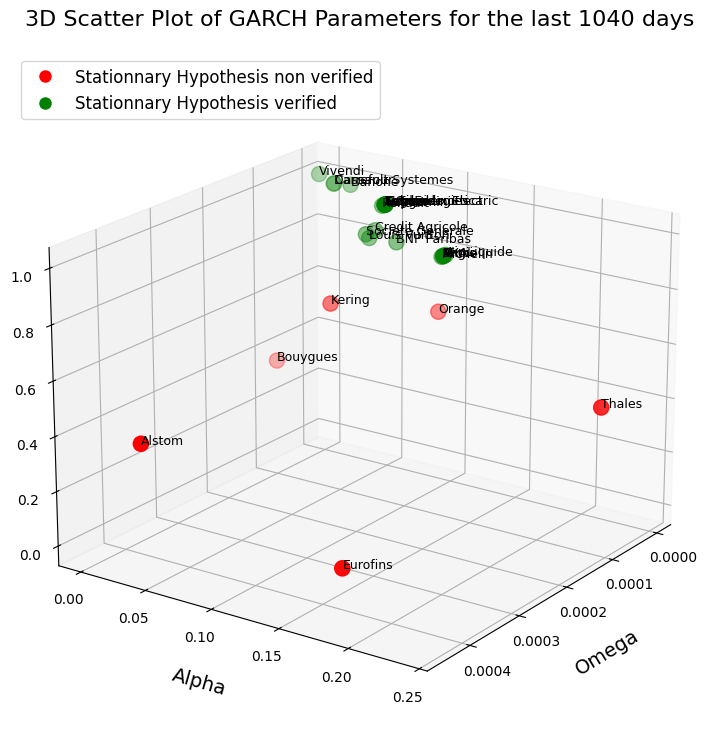

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Input data
strings = ["Societe Generale", "Air Liquide", "Airbus", "Alstom", "AXA", "BNP Paribas",
           "Bouygues", "Capgemini", "Carrefour", "Credit Agricole", "Danone",
           "Dassault Systemes", "Engie", "EssilorLuxottica", "Eurofins",
           "Kering", "L'Oreal", "Legrand", "Louis Vuitton", "Michelin",
           "Orange", "Renault", "Safran", "Schneider Electric", "Thales",
           "TotalEnergies", "Vinci", "Vivendi"]

mus = []
omegas = []
alphas = []
betas = []



#number of days we will use to estimate garch params
number_of_days = 52*5*4

for string in strings:
    r_t = last_logarithmic_returns(string, number_of_days)
    #We will use the library because the esmation we constructed takes too much time to compute
    mu, omega, alpha, beta = optimize_garch_one_GARCHLIBRARY(r_t)
    mus.append(mu)
    omegas.append(omega)
    alphas.append(alpha)
    betas.append(beta)


#THIS CODE IS USED TO SAVE THE GARCH PARAMS IN AN EXCEL FILE
#data = {
#    "Stock": strings,
#    "Mu (μ)": mus,
#    "Omega (ω)": omegas,
#    "Alpha (α)": alphas,
#    "Beta (β)": betas
#}
#df = pd.DataFrame(data)
#output_file = "garch_parameters.xlsx"
#df.to_excel(output_file, index=False)
#print(f"GARCH parameters saved to {output_file}")


# Calculate colors based on alpha + beta
colors = ["red" if alphas[i] + betas[i] < 0.8 else "green" for i in range(len(strings))]

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')


sc = ax.scatter(omegas, alphas, betas, c=colors, s=120, marker='o', label='GARCH Parameters')

for i in range(len(strings)):
    ax.text(omegas[i], alphas[i], betas[i], strings[i], fontsize=9, color='black')

ax.set_xlabel('Omega', fontsize=14, labelpad=15)
ax.set_ylabel('Alpha', fontsize=14, labelpad=15)
ax.set_zlabel('Beta', fontsize=14, labelpad=15)

ax.set_title('3D Scatter Plot of GARCH Parameters for the last '+str(number_of_days)+' days', fontsize=16, pad=20)

#view 
ax.grid(True)
ax.view_init(elev=20, azim=35)

#to verify if the stationnary hypothesis (alpha+beta should be less than one but close to 1)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Stationnary Hypothesis non verified', markersize=10, markerfacecolor='red')
green_patch = plt.Line2D([0], [0], marker='o', color='w', label='Stationnary Hypothesis verified', markersize=10, markerfacecolor='green')
ax.legend(handles=[red_patch, green_patch], loc='upper left', fontsize=12)
plt.show()




### Remark :
Classifying companies using techniques like SVM classification on the basis of $\omega$, $\alpha$, and $\beta$ could provide additional insights but is beyond the scope of this document.

## Most Estimated Coming Price

In this section, we will use the **GARCH Model** to build **stochastic trajectories** of both **volatility** and **logarithmic returns**. This will help us estimate a potential **coming price** based on the parameters estimated from the GARCH model.

   - Start by estimating the **GARCH parameters** of the given equity ('**string**') using the dataset from the **last_number_days**.

   - Create **Number_of_simulations** stochastic paths for volatility and logarithmic returns.  
   - For each path, determine the **coming price** of the equity over a specific time horizon '**H**', referred to as **number_coming_days** in the following code.
  
   - Generate a histogram of all the **coming prices** obtained from the **Number_of_simulations** paths.  
   - Identify the price with the **highest probability of occurrence** based on the histogram.

This approach allows us to estimate the most likely **coming price** of the equity using a stochastic framework.


In [174]:

#create a path for log_returns and volatility 
def create_projection_GARCH1_1(mean,realized_volatility,number_of_days,omega,alpha,beta) :
    coming_returns = []
    sigma_list = []
    sigma2 = realized_volatility
    
    for i in range(number_of_days):
        Z_t = np.random.normal(0, 1)
        sigma2 = omega + alpha * (sigma2 * Z_t**2) + beta * sigma2
        sigma_t = np.sqrt(sigma2)
        sigma_list.append(sigma_t)
        r_t = mean + sigma_t * Z_t
        coming_returns.append(r_t)
    
    return coming_returns,sigma_list

#convering log_returns to prices
def convert_log_returns_to_prices(r_t,initial_price) :
    cumulative_log_returns = np.cumsum(r_t)
    prices = initial_price * np.exp(cumulative_log_returns)
    return prices


In [175]:

#this function creates a path for a certain horizon 'number_coming_days', and volatility of a certain stock based on 
#data from the last 'number_of_days' to estimate Garch(1,1) params

def create_price_projection_GARCH1_1(string,number_of_days,number_coming_days) :
    r_t = last_logarithmic_returns(string,number_of_days)
    mu,omega,alpha,beta =   optimize_garch_one_GARCHLIBRARY(r_t)
    realized_volatility = (np.var(r_t))
    log_returns,sigma_list = create_projection_GARCH1_1(mu,realized_volatility,number_coming_days,omega,alpha,beta)
    initial_price  = get_access_to_data(string,number_of_days+number_coming_days-1)[-1]
    return convert_log_returns_to_prices(log_returns,initial_price),sigma_list

#this function does the same thing except we can control the first_date (we are not restricted to the last days of the data)
def create_price_projection_GARCH1_1_1_2(string,first_date,number_of_days,number_coming_days) :

    realized_volatility = (np.var(r_t))
    mu,omega,alpha,beta =   optimize_garch_one_GARCHLIBRARY(r_t)
    log_returns,sigma_list = create_projection_GARCH1_1(mu,realized_volatility,number_coming_days,omega,alpha,beta)
    initial_price  = get_prices(string,first_date,number_of_days)[-1]
    return convert_log_returns_to_prices(log_returns,initial_price),sigma_list

In [176]:

#this function uses Monte Carlo simulations to predict the most probable price after 'number_coming_days'
def predict_price_GARCH1_1(string,  first_date,   number_of_days,  number_coming_days,   Number_of_simulations) :
    actual_coming_price = logarithmic_returns_price(string,first_date,number_of_days,number_coming_days)[1]
    last_prices = []

    for _ in range(Number_of_simulations) :
        prices,sigma_list = create_price_projection_GARCH1_1_1_2(string,first_date,number_of_days,number_coming_days)
        last_prices.append(prices[-1])

    hist, bin_edges = np.histogram(last_prices, bins=30, density=True)
    max_bin_index = np.argmax(hist)
    most_probable_price = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2

    return most_probable_price,actual_coming_price
    
    

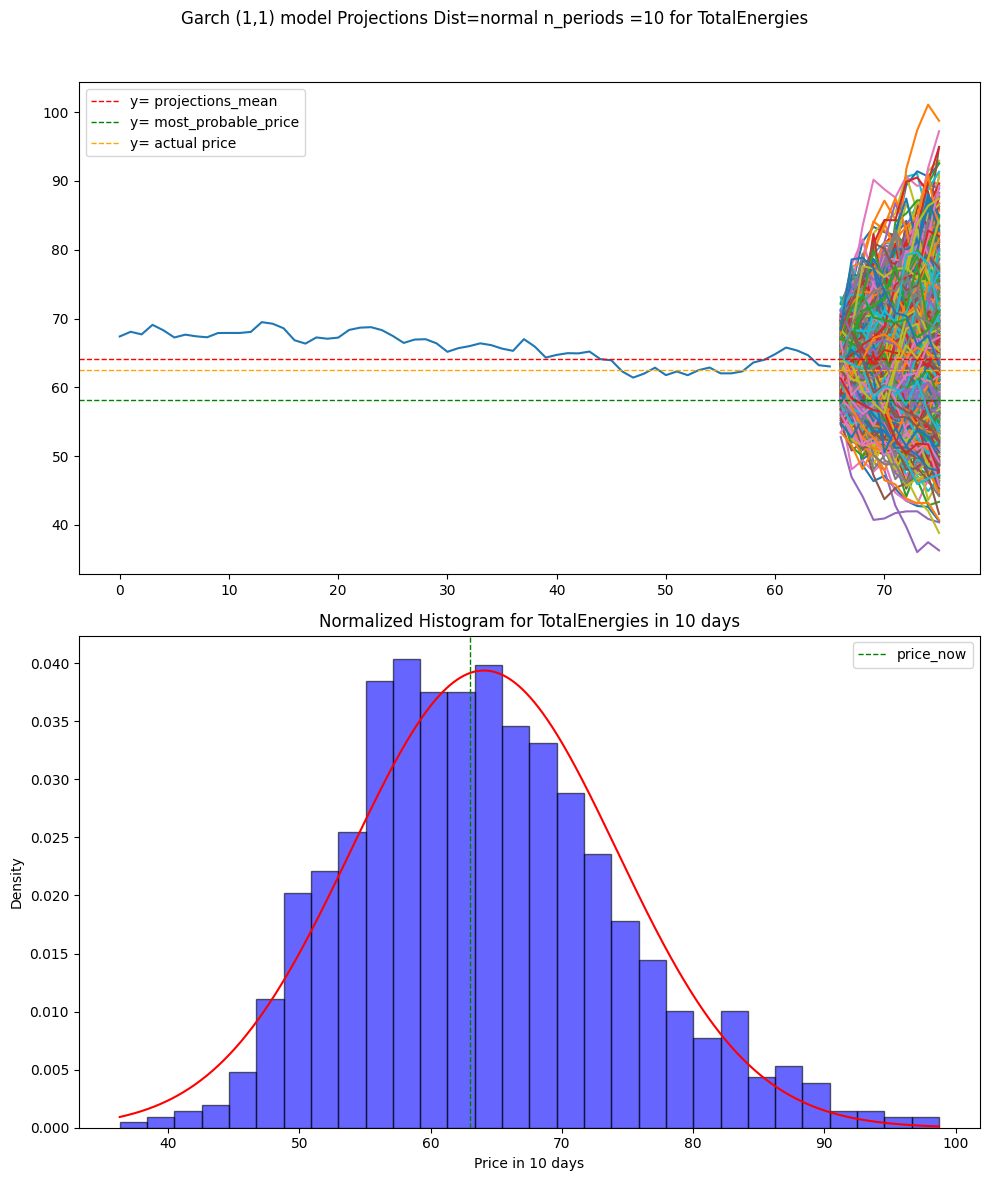

In [178]:

Number_of_simulations = 1000
number_coming_days = 10
number_of_days = 66
first_date = 120 #choose a random date in the dataset
dist = "normal" #there are other examples in which the distribution used would be a Student distribution


intial_time = [i for i in range(number_of_days)]
coming_time = [i for i in range(number_of_days,number_of_days+number_coming_days)]


strings = ["TotalEnergies"]


for string in strings :
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))
    fig.suptitle("Garch (1,1) model Projections Dist="+str(dist)+" n_periods ="+str(number_coming_days)+" for "+string)
    Y = get_prices(string,first_date,number_of_days)

    axes[0].plot(intial_time,Y)
    last_prices = []
    sigmas = [[] for i in range(number_coming_days)]

    for n in range(Number_of_simulations) :
        prices,sigma_list =create_price_projection_GARCH1_1_1_2(string,first_date,number_of_days,number_coming_days)
        actual_coming_price = logarithmic_returns_price(string,first_date,number_of_days,number_coming_days)[1]
        for i in range(len(sigmas)) :
            sigmas[i].append(sigma_list[i])

        if max(prices) < 2*Y[-1] :
            axes[0].plot(coming_time,prices)
            last_prices.append(prices[-1])
    

    last_prices = [p for p in last_prices if p <= 2 * Y[-1]]
    axes[0].axhline(y= statistics.mean(last_prices), color='red', linestyle='--', linewidth=1, label='y= projections_mean')    
    axes[1].hist(last_prices, bins=30, density=True, color='blue', alpha=0.6, edgecolor='black')
    
    hist, bin_edges = np.histogram(last_prices, bins=30, density=True)
    max_bin_index = np.argmax(hist)


    #we estimated the most_probable_price as the one who has the biggest value in the histogram
    most_probable_price = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2

    axes[0].axhline(y= most_probable_price, color='green', linestyle='--', linewidth=1, label='y= most_probable_price')
    axes[0].axhline(y= actual_coming_price, color='orange', linestyle='--', linewidth=1, label='y= actual price')


    x = np.linspace(min(last_prices), max(last_prices), 1000)
    pdf = norm.pdf(x, np.mean(last_prices), np.std(last_prices))
    axes[1].plot(x, pdf, color='red')
    axes[1].axvline(x= Y[-1], color='green', linestyle='--', linewidth=1, label='price_now')
    axes[1].set_xlabel('Price in '+str(number_coming_days)+ " days")
    axes[1].set_ylabel('Density')
    axes[1].set_title('Normalized Histogram for '+string+" in "+str(number_coming_days)+" days")
    axes[1].legend()
    axes[0].legend()
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()


    

## AIC, BIC Tests 
In the last cell, we found that in most cases the predicted price provided by the Garch(1,1) Model is not accurate.
So, in this section we aim to try to evaluate other GARCH(p,q) using 2 meaningful Test : **AIC Test** and **BIC Test**.

The Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) are commonly used to compare model performance. These criteria penalize models for having more parameters to avoid overfitting. The formulas for AIC and BIC are given as:
$$
\text{AIC} = -2\ln(\mathcal{L}) + 2k, \quad \text{BIC} = -2\ln(\mathcal{L}) + k\ln(n)
$$

where : 
- $\mathcal{L}$ : calculated likelihood
- $k$ : number of parameters
- $n$ : number of observations


The AIC and BIC tests will help us determine which GARCH(p,q) model is best for each company.  
We have therefore calculated, in the following code, the AIC and BIC values certain GARCH models for some **CAC40** stocks.

In [ ]:
from arch import arch_model

#aic and bic tests 
#we well use the library arch here because we didnt constuct code that lets us compute GARCH(1,2) and GARCH(2,1) volatilities
number_of_days = 260
pq_values = [(1,1),(1,2),(2,1)]

aic_1_1 = []
bic_1_1 = []
aic_1_2 = []
bic_1_2 = []
aic_2_1 = []
bic_2_1 = []

data = {
    'Stock': strings,
    'AIC_1_1': aic_1_1,
    'BIC_1_1': bic_1_1,
    'AIC_1_2': aic_1_2,
    'BIC_1_2': bic_1_2,
    'AIC_2_1': aic_2_1,
    'BIC_2_1': bic_2_1,

}
for string in strings :
    r_t = last_logarithmic_returns(string,number_of_days)
    model_1 = arch_model(r_t, vol='Garch', p=1, q=1).fit(disp='off')
    model_2 = arch_model(r_t, vol='Garch', p=1, q=2).fit(disp='off')
    model_3 = arch_model(r_t, vol='Garch', p=2, q=1).fit(disp='off')

    aic_1_1.append(model_1.aic)
    bic_1_1.append(model_1.bic)

    aic_1_2.append(model_2.aic)
    bic_1_2.append(model_2.bic)

    aic_2_1.append(model_3.aic)
    bic_2_1.append(model_3.bic)

df = pd.DataFrame(data)
output_file = 'AIC_BIC_values_garch.xlsx'
df.to_excel(output_file, index=False)



C:\Users\TNANI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001487. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\TNANI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001487. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning

### AIC and BIC Values for Different GARCH Models

<div style="display: flex; justify-content: space-between;">

<div style="width: 48%;">

**Table 1: AIC values for different GARCH Models**

| Stock/(p,q)        | (1,1)  | (1,2)  | (2,1)  |
|--------------------|--------|--------|--------|
| Societe Generale   | -2362  | -2360  | -2403  |
| Air Liquide        | -2900  | -2887  | -2889  |
| Airbus             | -2563  | -2549  | -2546  |
| Alstom             | -2026  | -2101  | -2106  |
| AXA                | -2749  | -2904  | -2773  |
| BNP Paribas        | -2556  | -2570  | -2558  |
| Bouygues           | -2953  | -2970  | -2805  |
| Capgemini          | -2524  | -2522  | -2601  |
| Carrefour          | -2731  | -2725  | -2722  |
| Credit Agricole    | -2631  | -2740  | -2655  |
| Danone             | -3012  | -2998  | -3022  |

</div>

<div style="width: 48%;">

**Table 2: BIC values for different GARCH Models**

| Stock/(p,q)        | (1,1)  | (1,2)  | (2,1)  |
|--------------------|--------|--------|--------|
| Societe Generale   | -2330  | -2385  | -2201  |
| Air Liquide        | -2884  | -2882  | -2874  |
| Airbus             | -2546  | -2540  | -2538  |
| Alstom             | -2009  | -2003  | -2000  |
| AXA                | -2732  | -2726  | -2725  |
| BNP Paribas        | -2540  | -2538  | -2531  |
| Bouygues           | -2937  | -2932  | -2930  |
| Capgemini          | -2507  | -2501  | -2501  |
| Carrefour          | -2714  | -2708  | -2709  |
| Credit Agricole    | -2614  | -2629  | -2632  |
| Danone             | -2995  | -2989  | -3007  |

</div>

</div>


We observe no significant difference in AIC and BIC values between the GARCH(1,1), GARCH(1,2), and GARCH(2,1) models. However, we always opt for the GARCH(1,1) model as it produces accurate results while requiring fewer parameters, making it more convenient.

## Evaluating the GARCH(1,1) Model : 
Firstly, the **GARCH(1,1)** model does not give accurate results in terms of predicting the **coming price** of a certain equity over a specific time horizon. The hypothesis in which we assume that **log returns are uncorrelated** may explain the gap in the results.

However, the model does not aim to predict the future price directly. Its main goal is to model the **upcoming volatility** based on the results of a given dataset. This can be particularly useful in applications such as:

- **Option pricing**: Volatility is a key input in pricing options.
- **Market trend evaluation**: The model helps in assessing the potential trend and uncertainty in the market.

In the following section, we will evaluate the **GARCH(1,1)** model's volatility by comparing it with the actual observed volatility in the market.

### Mean MAE Error

To evaluate the performance of the GARCH(1,1) model, we calculate the Mean Absolute Percentage Error (MAE) between the projected volatility and the real volatility. The formula for the mean MAE error is given by:
$$
\text{Mean MAE Error} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{\bar{\sigma}_{\text{proj}, i} - \bar{\sigma}_{\text{real}, i}}{\bar{\sigma}_{\text{real}, i}} \right| \times 100,
$$

where:
- n : Total number of observations (time periods or samples),
- $ \bar{\sigma}_{\text{proj}, i} $: Mean projected volatility for the i-th observation,
- $ \bar{\sigma}_{\text{real}, i} $: Mean real volatility for the i-th observation.


The Mean MAE Error gives as a certain area in which The real mean volatility would be based on the projections of Garch(1,1) volatility model. Our goal is to minimize it to make the estimation of the mean volatility as accurate as possible.

[np.float64(-0.02772331420171203), np.float64(0.016912398097496614), np.float64(0.010810916104215456), np.float64(0.017359960862480598), np.float64(-0.014905218911829587), np.float64(-0.001226617755759096), np.float64(0.027539945981550438), np.float64(-0.016554177882504413), np.float64(-0.04882051364362985), np.float64(-0.05334161531324775), np.float64(-0.01524161596861709), np.float64(0.018932276088022636), np.float64(0.04133090719914651), np.float64(0.05956554009250744), np.float64(0.0027210901143605863), np.float64(0.0226875402667948), np.float64(-0.019371787417350884), np.float64(0.16522366442991407), np.float64(0.0737434742455492), np.float64(-0.026655438146647756), np.float64(-0.03819908868165565), np.float64(0.009061224846979556), np.float64(0.01714114754704451), np.float64(0.007850874475738854), np.float64(0.005118841158906977), np.float64(-0.008055700832216838), np.float64(0.003669728888962623), np.float64(0.013100624045698056), np.float64(0.05258193108005251), np.float64(0.00

C:\Users\TNANI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004191. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


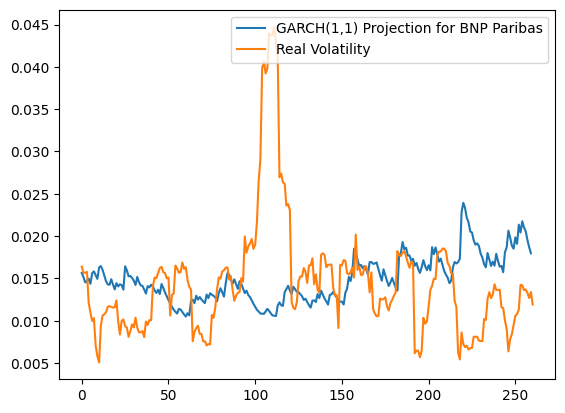

MAE Error = 21.609273221003516


In [ ]:

#ploting the real and the Garch(1,1) volatility to be able to compare
def coming_volatility(string,first_date,number_of_days,number_coming_days) :
    r_t,actual_coming_price = logarithmic_returns_price(string,first_date,number_of_days,number_coming_days)
    print(r_t)
    mu,omega,alpha,beta =   optimize_garch_one_GARCHLIBRARY(r_t)
    model = arch_model(r_t, vol='Garch',p=1, q=1,dist='normal')
    fit = model.fit(disp="off")

    window_size = 10
    actual_volatility = [np.std(r_t[max(0, i-window_size+1):i+1]) for i in range(len(r_t))]
    realized_volatility = actual_volatility[-1-number_coming_days]**2
    coming_returns,sigma_list = create_projection_GARCH1_1(mu,realized_volatility,number_coming_days,omega,alpha,beta)

    plt.plot(sigma_list,label ="GARCH(1,1) Projection for "+string)
    plt.plot(actual_volatility[-1-number_coming_days:], label="Real Volatility")
    plt.legend()
    plt.show()
    real_mean_volatility = statistics.mean(actual_volatility[-1-number_coming_days :])
    projected_mean_volatility = statistics.mean(sigma_list)
    mae_error  = abs(projected_mean_volatility-real_mean_volatility*1.25)*100/real_mean_volatility 

    return sigma_list, actual_volatility[-1-number_coming_days:],mae_error

strings = ["BNP Paribas"]


for string in strings :
    mean_errors = []
    number_of_days = 52*5*3 #data from three last years 
    number_coming_days =52*5 #projection in the coming year
    first_date = 300
    sigma_list,x,mae_error = coming_volatility(string,first_date,number_of_days,number_coming_days)
    mean_errors.append(mae_error)
    print("MAE Error = "+str(statistics.mean(mean_errors)))



Once we are able to calculate the MAE Error, it is easy to caculate the mean MAE Error by shifting the 'first_date'.
So we repeat this procedure for the past 8 years, shifting the **starting point** of the dataset by **one month** for each iteration.

The results are shown in the following table :

Mean MAE Error for Different CAC40 Stocks

The following table shows the *Mean MAE Error* values for different stocks in the CAC40 index:


| Stock            | Mean MAE Error |
|------------------|----------------|
| Societe Generale | 8.6700         |
| Air Liquide      | 16.2690        |
| Airbus           | 14.3750        |
| Alstom           | 10.6530        |
| AXA              | 8.9000         |
| BNP Paribas      | 8.8200         |
| Bouygues         | 20.5450        |
| Capgemini        | 12.8500        |
| Carrefour        | 9.9770         |
| Credit Agricole  | 10.4100        |
| Danone           | 15.4630        |



The Table highlights that the GARCH(1,1) model performs well in capturing volatility dynamics for most stocks in the CAC40 index, as evidenced by relatively low mean MAE errors. However, the error increases for stocks with highly irregular or extreme volatility patterns, suggesting potential limitations of the model in such scenarios.

# Introduction to Heston Volatility

The GARCH model is widely used in financial modeling, and the previous results demonstrate that it is a robust approach for capturing volatility dynamics. However, a major limitation has emerged: the GARCH model struggles to accurately capture periods of significant changes in volatility, such as those caused by market shocks or structural shifts. This limitation underscores the need to explore alternative approaches to better model these dynamics.

Among the stochastic volatility models, the Heston model is particularly prominent.

Mathematically, the Heston model is defined by the following equations :


$$
dS_t = \mu S_t \, dt + \sqrt{v_t} S_t \, dW_t^S,
$$
$$
dv_t = \kappa (\theta - v_t) \, dt + \sigma \sqrt{v_t} \, dW_t^v,
$$

where:
- $S_t$: Price of the underlying asset at time  $t$ ,
- $v_t$: Variance of the asset price at time $t$ (equivalent to $\sigma$ in the last sections),

- $\kappa$ : Speed of mean reversion of the variance,
- $\theta$: Long-term mean of the variance,
- $\sigma$: Volatility of the variance (vol of vol),
- $W_t^S$ and $W_t^v$: Two Wiener processes (Brownian motions),
- $\rho$: Correlation between $W_t^S$ and $W_t^v$

## Computing Heston Paths

In discrete form, the update equation is:
$$
v_{t+\Delta t} = v_t + \kappa (\theta - v_t) \Delta t + \sigma \sqrt{v_t} \sqrt{\Delta t} \, Z_2
$$
where:
- $ Z_2 \sim \mathcal{N}(0, 1) $: A standard normal random variable.



### Stock Price Process $S_t$

In discrete form, the Stock Price follows the following equation :

$$
S_{t+\Delta t} = S_t \cdot \exp\left[\left(r - q - \frac{1}{2} v_t\right) \Delta t + \sqrt{v_t} \sqrt{\Delta t} \, Z_1\right]
$$

where : 
- $ Z_1 \sim \mathcal{N}(0, 1) $ is a standard normal random variable.

- $Z_2$ = $\rho$ $Z_1$ + $\sqrt{1 - \rho^2} Z_3$ and, $ Z_3 \sim \mathcal{N}(0, 1) $ is an independent standard normal random variable.


In the following code we compute a path of Heston model using these equations.

In [19]:
import numpy as np
from scipy.optimize import minimize

#function to compute a Heston path for S (equity), v (volatility)
def heston_simulation(params,S0,v0,dt,N):
    mu, kappa, theta, sigma, rho = params
    S = np.zeros(N)
    v = np.zeros(N)
    S[0],v[0] = S0,v0

    for t in range(1, N):
        W1= np.random.normal(0,np.sqrt(dt))
        W2= np.random.normal(0,np.sqrt(dt))
        W2= rho*W1 + np.sqrt(1-rho**2)*W2 
        v[t] = v[t-1] +kappa*(theta-v[t-1])*dt+ sigma*np.sqrt(max(v[t-1],0))*W2
        v[t] = max(v[t], 0)  
        
        S[t] = S[t-1]+mu*S[t-1]*dt + np.sqrt(max(v[t-1],0))*S[t-1]*W1

    return S,v


The payoff of a call option at maturity $T$ is:
$$
\text{Payoff} = \max(S_T - K, 0)
$$


Using $n_{\text{paths}}$ simulated paths, the average discounted payoff is used to estimate the option price:
$$
\text{Option Price} = e^{-rT} \cdot \mathbb{E}[\text{Payoff}]
$$
This is approximated numerically as:
$$
\text{Option Price} = e^{-rT} \cdot \frac{1}{n_{\text{paths}}} \sum_{i=1}^{n_{\text{paths}}} \max(S_T^{(i)} - K, 0),
$$
where $S_T^{(i)}$ is the terminal stock price for the \(i\)-th simulated path.

In [56]:
import numpy as np
from scipy.optimize import minimize


def heston_monte_carlo(S0, K, T, r, q, kappa, theta, sigma, rho, v0, n_paths=10000, n_steps=250):
    dt = T / int(n_steps) 

    S = np.zeros((n_paths, int(n_steps) + 1)) 
    v = np.zeros((n_paths, int(n_steps) + 1))
    
    S[:, 0] = float(S0)
    v[:, 0] = v0

    for t in range(1, int(n_steps) + 1):  
        z1 = np.random.normal(size=n_paths)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=n_paths)

        v[:, t] = v[:, t-1] +kappa * (theta - v[:, t-1]) * dt +sigma * np.sqrt(v[:, t-1]) * np.sqrt(dt) * z2
        v[:, t] = np.maximum(v[:, t], 0)  
        S[:, t] = (S[:, t-1] * np.exp((r - q - 0.5 * v[:, t-1]) * dt + np.sqrt(v[:, t-1]) * np.sqrt(dt) * z1))

    payoff = np.maximum(S[:, -1] - K, 0)
    option_price = np.exp(-r * T) * np.mean(payoff)
    return option_price



# Estimation of Heston Parameters 

Now that we are able to replicate the Call option price using the Monte-Carlo method, we are going to adjust our model so that it replicates **market_prices** as closely as possible. 

We are going to minimize the following error :
$$
\text{error} = \sum_{i=1}^n \left(C_{\text{mkt}, i} - C_{\text{model}, i}\right)^2.
$$

-The optimization process adjusts the Heston model parameters $\kappa$, $\theta$, $\sigma$, $\rho$ to minimize this error, ensuring the model replicates market prices as closely as possible.


In [63]:
def heston_objective(params,strikes,maturities,market_prices,S0,r,q):
    kappa, theta, sigma, rho, v0 = params
    model_prices = []
    for K, T, C_mkt in zip(strikes, maturities, market_prices):
        C_model = heston_monte_carlo(S0, K, T, r, q, kappa, theta, sigma, rho, v0)
        model_prices.append(C_model)

    error = np.sum((np.array(market_prices) - np.array(model_prices))**2)
    return error

def calibrate_heston(S0, strikes, maturities, market_prices, r, q, n_paths=10000, n_steps=250):
    initial_params = [2.0, 0.04, 0.3, -0.7, 0.04]  # kappa, theta, sigma, rho, v0

    bounds = [(0.01, 10),  # kappa
              (0.01, 1),   # theta
              (0.01, 2),   # sigma
              (-1, 1),     # rho
              (0.01, 1)]   # v0
    result = minimize(heston_objective, initial_params, args=(strikes, maturities, market_prices, S0, r, q), 
                      bounds=bounds, method='Powell')

    return result.x, result.fun


#Example with BNP Paribas
S0 = 100  
r = 0.03  
q = 0



strikes = [40,45,50,54,55,56,58,60,65,70,80,90,
           40,45,50,54,55,56,58,60,65,70,80,90,
           40,45,50,55,56,58,60,65,70,80,90]

call_prices = [16.31, 11.48, 7.39, 4.67, 4.11, 3.56, 2.63, 1.88, 0.76, 0.32, 0.1, 0.01,
               16.61, 12.18, 8.25, 5.70, 5.04, 4.59, 3.55, 2.76, 1.36, 0.65, 0.17, 0.04,
               16.97, 12.68, 8.94, 5.79, 5.37, 4.37, 3.46, 1.97, 1.07, 0.28, 0.07]

maturities = [5/12, 5/12, 5/12, 5/12, 5/12, 5/12, 5/12, 5/12, 5/12, 5/12, 5/12, 5/12,
              8/12, 8/12, 8/12, 8/12, 8/12, 8/12, 8/12, 8/12, 8/12, 8/12, 8/12, 8/12,
              11/12, 11/12, 11/12, 11/12, 11/12, 11/12, 11/12, 11/12, 11/12, 11/12, 11/12]

calibrated_params, error = calibrate_heston(S0, strikes, maturities, call_prices, r, q)
print("Calibrated Parameters:", calibrated_params)


Calibrated Parameters: [7.64274947 0.02302406 0.20755306 0.23606798 0.05808761]


This approach takes too much time to compute, and does not give meaningful estimation **(the Calibration error is way too high)**.

This may because of the **size** of the dataset **(which includes only 35 datapoints)**.

Once, we are able to estimate Heston Parameters, we are able to compute a Heston Path, using these parameters.
In the following code, we made an average **GARCH(1,1)** and **Heston path**, which we will compare.



We won't be able to compare with the historical volatility because we didn't fing Historical data of Call Prices. So we are going to compare only these two models.

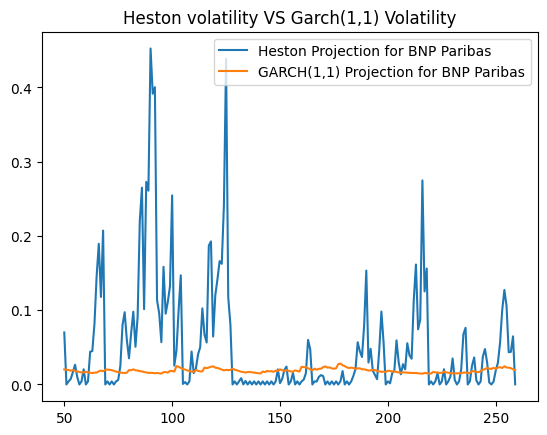

In [ ]:
string = "BNP Paribas"

N = 52*5
dt = 1

v0 = 0.058  
kappa = 7.6  
theta = 0.02  
sigma = 0.2     
rho = 0.236


params = [kappa,theta,sigma,rho,v0]
S_list,v_list = heston_simulation(params,S0,v0,N/250,N)
time = [i for i in range(len(v_list))]

plt.title("Heston volatility VS Garch(1,1) Volatility")
plt.plot(time[50:],v_list[50:], label = 'Heston Projection for '+string)

first_date =0
number_of_days = 52*5*3
number_coming_days = N
r_t,actual_coming_price = logarithmic_returns_price(string,first_date,number_of_days,number_coming_days)
mu,omega,alpha,beta =   optimize_garch_one_GARCHLIBRARY(r_t)
coming_returns,sigma_list = create_projection_GARCH1_1(mu,v0,number_coming_days,omega,alpha,beta)

plt.plot(time[50:],sigma_list[50:],label ="GARCH(1,1) Projection for "+string)
plt.legend()
plt.show()



Unlike the Garch Model, The Heston Model has been able to model periods ccurately periods of significant change in volatility.

**However**, The model does not take into account the **range of the volatility**. In deed, in most cases (especially for equities in the CAC40), the volatility should not exceed **15-20%** .

A **Simple Solution** would be to add a "threshold" $v_c$ of the volatility.

There are other models, in which they create a dynamic "threshold" depending on the evolution of the market, but it is beyond our scope of study in this project.



In [100]:
def new_heston_simulation(params,S0,v0,dt,N,v_cap):
    mu, kappa, theta, sigma, rho = params
    S = np.zeros(N)
    v = np.zeros(N)
    S[0],v[0] = S0,v0

    for t in range(1, N):
        W1= np.random.normal(0,np.sqrt(dt))
        W2= np.random.normal(0,np.sqrt(dt))
        W2= rho*W1 + np.sqrt(1-rho**2)*W2 
        v[t] = v[t-1] +kappa*(theta-v[t-1])*dt+ sigma*np.sqrt(max(v[t-1],0))*W2
        v[t] = max(v[t], 0)  
        v[t] = min(v[t], v_cap)
        
        S[t] = S[t-1]+mu*S[t-1]*dt + np.sqrt(max(v[t-1],0))*S[t-1]*W1

    return S,v


def new_heston_monte_carlo(S0, K, T, r, q, kappa, theta, sigma, rho, v0,vol_cap, n_paths=10000, n_steps=250):
    dt = T / int(n_steps) 

    S = np.zeros((n_paths, int(n_steps) + 1)) 
    v = np.zeros((n_paths, int(n_steps) + 1))
    
    S[:, 0] = float(S0)
    v[:, 0] = v0

    for t in range(1, int(n_steps) + 1):  
        z1 = np.random.normal(size=n_paths)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=n_paths)

        v[:, t] = v[:, t-1] +kappa * (theta - v[:, t-1]) * dt +sigma * np.sqrt(v[:, t-1]) * np.sqrt(dt) * z2
        v[:, t] = np.maximum(v[:, t], 0) 
        
        #this is the line that we added to calibrate the heston model :
        v[:, t] = np.minimum(v[:, t], vol_cap)

        S[:, t] = (S[:, t-1] * np.exp((r - q - 0.5 * v[:, t-1]) * dt + np.sqrt(v[:, t-1]) * np.sqrt(dt) * z1))

    payoff = np.maximum(S[:, -1] - K, 0)
    option_price = np.exp(-r * T) * np.mean(payoff)
    return option_price



- Note that adding **$v_c$** means changing the function we optimize, so we need to search for Heston parameters another time.                     
For that, we need to implement the same functions to optimize Heston Parameters while taking into account **$v_C$**.

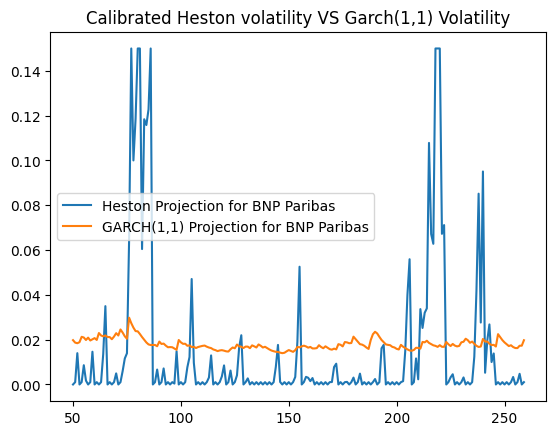

In [229]:
string = "BNP Paribas"

N = 52*5
dt = 1

v_cap =0.15
v0 = 0.058  
kappa = 7.6  
theta = 0.02  
sigma = 0.05     
rho = 0.236


params = [kappa,theta,sigma,rho,v0]
S_list,v_list = new_heston_simulation(params,S0,v0,N/250,N,v_cap)
time = [i for i in range(len(v_list))]

plt.title("Calibrated Heston volatility VS Garch(1,1) Volatility")
plt.plot(time[50:],v_list[50:], label = 'Heston Projection for '+string)

first_date =0
number_of_days = 52*5*3
number_coming_days = N
r_t,actual_coming_price = logarithmic_returns_price(string,first_date,number_of_days,number_coming_days)
mu,omega,alpha,beta =   optimize_garch_one_GARCHLIBRARY(r_t)
coming_returns,sigma_list = create_projection_GARCH1_1(mu,v0,number_coming_days,omega,alpha,beta)

plt.plot(time[50:],sigma_list[50:],label ="GARCH(1,1) Projection for "+string)
plt.legend()
plt.show()